In [1]:
import os
import sys
import copy
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from tqdm import tqdm
from numpy.fft import fft, ifft
from scipy.signal import correlate2d
from matplotlib import rc
#Direct input 
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 20,
          'legend.fontsize': 20,
          'legend.handlelength': 2,
          'font.family' : 'sans-serif',
          'font.sans-serif':['Helvetica'],
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

# Get current working directory and project root directory
cwd = os.getcwd()
rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0])
if not rd.endswith('stochastic-travel-demand-modelling'):
    rd = os.path.join(cwd.split('stochastic-travel-demand-modelling/', 1)[0],'stochastic-travel-demand-modelling')

if rd not in sys.path:
    sys.path.append(rd)

# from models.singly_constrained.spatial_interaction_model import SpatialInteraction

/Users/Yannis/.pyenv/versions/3.7.5/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]


# Import data

In [2]:
dataset = 'commuter_ward'
constrained = 'singly'

In [3]:
# Import commuter Borough to Borough data
cost_matrix = np.loadtxt(os.path.join(rd,f'data/input/{dataset}/cost_matrix.txt'))
origin_supply = np.loadtxt(os.path.join(rd,f'./data/input/{dataset}/origin_supply.txt'))
initial_destination_sizes = np.loadtxt(os.path.join(rd,f'./data/input/{dataset}/initial_destination_sizes.txt'))

o = origin_supply/np.sum(origin_supply)
c = cost_matrix/np.sum(cost_matrix)
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))

orig_locs = np.loadtxt(os.path.join(rd,f'./data/input/{dataset}/origin_locations.txt'))
dest_locs = np.loadtxt(os.path.join(rd,f'./data/input/{dataset}/destination_locations.txt'))

london_boundary = gpd.read_file('../data/input/misc/london_boundary.geojson')

N,M = cost_matrix.shape

alpha = 1.2
beta = 1400
delta = np.min(np.exp(xd))
gamma = 100
kappa = 1 + delta*M
epsilon = 1
theta = np.array([alpha,beta,delta,gamma,kappa,epsilon])

In [4]:
np.sum(initial_destination_sizes)

4581000.0

In [5]:
np.sum(cost_matrix)

9171.228658308206

In [6]:
np.sum(initial_destination_sizes)

4581000.0

In [7]:
np.min(np.exp(xd))

0.01178781925343811

In [8]:
np.min(cost_matrix)

0.03624043372875424

In [9]:
np.max(cost_matrix)

0.8476181560889813

true_beta 35630.56305630563
min cost contribution 0.037141217816547833
max cost contribution 0.868666998947804


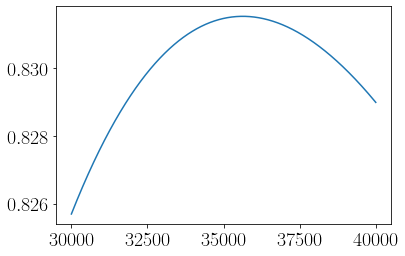

In [10]:
trials = np.linspace(30000,40000,10000)
y = [np.max(np.exp(-c*x))-np.min(np.exp(-c*x)) for x in trials]

plt.plot(trials,y)

true_beta = trials[np.argmax(y)]
print('true_beta',true_beta)

print('min cost contribution',np.min(np.exp(-c*true_beta)))
print('max cost contribution',np.max(np.exp(-c*true_beta)))

# Visualise destination sizes

In [11]:
# Set plot params
latent_factor = 10000
actual_factor = 10000

In [13]:
# fig,ax = plt.subplots(1,1,figsize=(20,20))
# ax.scatter(orig_locs[:, 0], orig_locs[:, 1], edgecolors='b', s=actual_factor*o, alpha=1,label=r'$O_i$')
# ax.scatter(dest_locs[:, 0], dest_locs[:, 1], edgecolors='r', s=latent_factor*np.exp(xd), alpha=1,label=r'$Y_j$')
# # Plot legend.
# lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=18)
# for i in range(len(lgnd.legendHandles)):
#     lgnd.legendHandles[i]._sizes = [120]
# plt.yticks([])
# plt.xticks([])
# plt.xlabel('Longitude',fontsize=25)
# plt.ylabel('Latitude',fontsize=25)

# london_boundary.boundary.plot(edgecolor='black',ax=ax,alpha=0.3)
# plt.savefig("../data/output/commuter_ward/actual/figures/log_latent_sizes.png",
#             dpi=1000, 
#             bbox_inches='tight',
#            transparent=True)

# Check convexity

In [14]:
def is_pos_semidef(M):
    return np.all(np.linalg.eigvals(M) >= 0)

def convexity_test(M):
    
    if is_pos_semidef(M):
        print('Potential function is convex.')
        return True
    else:
        print(f'alpha = {theta[0]}')
        print('Potential function is NOT convex.')
        return False

In [15]:
# si = SpatialInteraction(dataset)
# si.normalise_data()

# # Get destination sizes
# xd = si.normalised_initial_destination_sizes

# theta[0] = 1.01
# theta[1] = 0.04

# # Get hessian
# hessian = si.potential_hessian(xd,theta)

# # Run convexity test
# convexity_test(hessian)

# MCMC samples

## Low noise

### Sandbox

In [22]:
Ap = np.array([[ 0.00749674, 0.00182529], [ 0.00182529,  0.00709968]])
print(Ap[0,0]/Ap[0,1])
print(Ap[1,0]/Ap[1,1])

def transition(t):
    T = np.empty((2,2))
    T[0,0] = (1+t)*0.5
    T[0,1] = (1-t)*0.5
    T[1,0] = 0.5
    T[1,1] = 0.5*t
    return T

4.107150096696963
0.257094685957677


In [55]:
Ap

array([[1. , 0. ],
       [0.5, 0.5]])

In [52]:
Ap = np.array([[ 0.00749674,  0.00182529], [ 0.00182529,  0.00709968]])
# Ap = np.array([[ 0.01499348, 0.00365058], [ 0.00182529,  0.00709968]])
Ap = transition(1)

# Ap[0,0] = 0.00014398846809000215#0.0002199348
# Ap[0,1] = 0.000035058

# Ap[1,0] = 0.000035058 
# Ap[1,1] = 0.00014398846809000215

# Ap[0,0] = 0.00949674
# Ap[0,1] = 0.000182529

# Ap[1,0] = 0.000182529 
# Ap[1,1] = 0.00149674

print(Ap[0,0]/Ap[0,1])
print(Ap[1,0]/Ap[1,1])

theta_step = 1
n = 20000
burnin = 0#10000
ideal_theta_ar = 0.45
_print = False

inf
1.0


/Users/Yannis/.pyenv/versions/stdm/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [53]:
# Proposal and acceptance count
pc = 0
ac = 0

np.random.seed(888)

theta_initial = np.array([1.14, 0.02]) #  np.array([1.17097421, 0.25761399])
fake_samples = np.zeros((n,2))
fake_samples[0,:] = samples[0,:]
print(f'----- initial theta = {theta_initial} -----')
for i in tqdm(range(n)):

    theta_proposal = theta_initial + theta_step*np.dot(Ap, np.random.normal(0, 1, 2))
    
    for j in range(2):
        if theta_proposal[j] < 0.:
            theta_proposal[j] = -theta_proposal[j]
        elif theta_proposal[j] > 2.:
            theta_proposal[j] = 2. - (theta_proposal[j] - 2.)
        
    pc += 1

    if np.random.uniform(0,1,1) <= ideal_theta_ar:# np.random.uniform(0.4,0.5,1):

#         if _print:
#             print(f'inital theta = {theta_initial}')
#             print(f'theta accepted = {theta_proposal}')

        theta_initial = theta_proposal
        ac += 1
        
#         if _print:
#             print(f'theta AR =  {int(100*ac/pc)}%')
            
    if (i+1) % 1000 == 0:
        if _print:
            print(f'Iteration {i+1}')
            print(f'inital theta = {theta_initial}')
            print(f'theta accepted = {theta_proposal}')
            print(f'theta AR =  {int(100*ac/pc)}%')
        
    fake_samples[i,:] = theta_initial

 10%|▉         | 1961/20000 [00:00<00:00, 19036.47it/s]

----- initial theta = [1.14 0.02] -----


100%|██████████| 20000/20000 [00:00<00:00, 22341.33it/s]


RW mean = 1.0083550711223002
alpha ratio = 0.699497450451732
RW sd = 0.5818250538060172


RW mean = 1.0018155001908582
beta ratio = 0.312603142086031
RW sd = 0.5817394203558311


mean to sd ration 1.7330898085706872
good mean to sd ratio 148.39001212239688


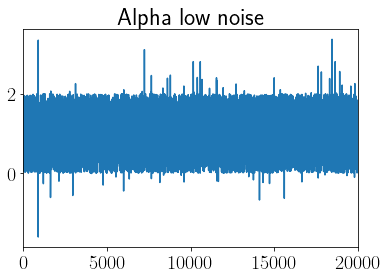

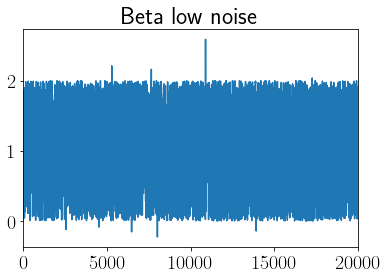

In [54]:
plt.figure(0)
plt.title("Alpha low noise")
print(f'RW mean = {np.mean(fake_samples[burnin:, 0])}')
print(f'alpha ratio = {np.mean(fake_samples[burnin:, 0])/1.4415421678393674}')
print(f'RW sd = {np.std(fake_samples[burnin:, 0])}')
plt.plot(fake_samples[burnin:, 0])
plt.xlim([0,n-burnin])
print('\n')

plt.figure(1)
plt.title("Beta low noise")
print(f'RW mean = {np.mean(fake_samples[burnin:, 1])}')
print(f'beta ratio = {np.mean(fake_samples[burnin:, 1])/3.2047518572770777}')
print(f'RW sd = {np.std(fake_samples[burnin:, 1])}')
plt.plot(fake_samples[burnin:, 1])
plt.xlim([0,n-burnin])
print('\n')

print('mean to sd ration', np.mean(fake_samples[burnin:, 0])/np.std(fake_samples[burnin:, 0]))
print('good mean to sd ratio',148.39001212239688)

Alpha ACF


<Figure size 432x288 with 0 Axes>

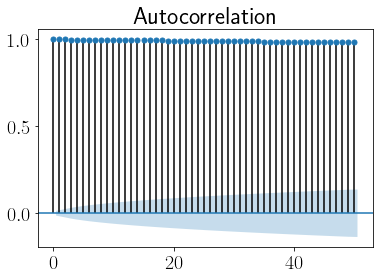

Beta ACF


<Figure size 432x288 with 0 Axes>

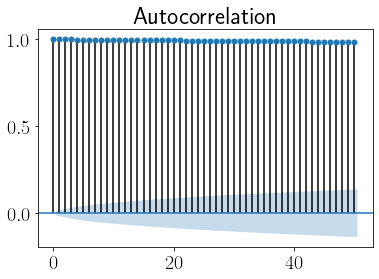

In [31]:
plt.figure(0)
print('Alpha ACF')
sm.graphics.tsa.plot_acf(fake_samples[burnin:,0], lags=50)
plt.show()

plt.figure(1)
print('Beta ACF')
sm.graphics.tsa.plot_acf(fake_samples[burnin:,1], lags=50)
plt.show()

### Produce posterior plots

In [20]:
# Choose whether to save the plot or not
low_save = True

# Last iteration 
last_it = -1

In [21]:
samples = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_theta_samples.txt"))
samples2 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_logsize_samples.txt"))
samples3 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_low_noise_sign_samples.txt"))

if last_it == -1:
    last_it = samples.shape[0]

In [ ]:
plt.figure(0)
plt.title("Alpha low noise")
plt.plot(samples[:last_it, 0])
plt.xlim([0,last_it])

In [ ]:
plt.figure(0)
plt.title("Beta low noise")
plt.plot(samples[:last_it, 1])
plt.xlim([0,last_it])

In [ ]:
plt.figure(0)
print('Alpha ACF')
sm.graphics.tsa.plot_acf(samples[:last_it,0], lags=50)
plt.show()

plt.figure(1)
print('Beta ACF')
sm.graphics.tsa.plot_acf(samples[:last_it,1], lags=50)
plt.show()

In [ ]:
print('Theta mean')
print(np.mean(samples,axis=0))
print('Theta sd')
print(np.std(samples,axis=0))

In [ ]:
np.exp(posterior_xd_mean+3*posterior_xd_sd)

In [ ]:
np.exp(posterior_xd_mean-3*posterior_xd_sd)

In [ ]:
# Posterior latent sizes
posterior_xd_mean = np.mean(samples2,axis=0)
posterior_xd_sd = np.std(samples2,axis=0)
print('Posterior latent sizes mean')
print(np.exp(posterior_xd_mean))
print('Posterior latent sizes sd')
print(posterior_xd_sd)
print('Actual latent sizes')
print(np.exp(xd))

In [ ]:
# Set factor for plotting
actual_factor = 1000
latent_factor = 10000

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.scatter(orig_locs[:, 0], orig_locs[:, 1], facecolor="None",edgecolors='b', s=actual_factor*o, alpha=1,label=r'$O_i$')
ax.scatter(dest_locs[:, 0], dest_locs[:, 1], facecolor="None",edgecolors='g', s=latent_factor*np.exp(posterior_xd_mean+3*posterior_xd_sd), alpha=1,label=r'$\hat{W}_j+3\sigma$')
ax.scatter(dest_locs[:, 0], dest_locs[:, 1], facecolor="None",edgecolors='r', s=latent_factor*np.exp(posterior_xd_mean-3*posterior_xd_sd), alpha=1,label=r'$\hat{W}_j-3\sigma$')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=18)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [120]
plt.yticks([])
plt.xticks([])
plt.xlabel('Longitude',fontsize=25)
plt.ylabel('Latitude',fontsize=25)

london_boundary.boundary.plot(edgecolor='black',ax=ax,alpha=0.3)
if low_save:
    plt.savefig("../data/output/commuter_ward/inverse_problem/figures/low_noise_posterior_latent_sizes.png",
            dpi=1000, 
            bbox_inches='tight',transparent=True)

In [ ]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax = sns.scatterplot(x=posterior_xd_mean, y=xd, s=100)
ax = ax.set(ylabel=r'$\log(Y_j)$', xlabel=r'$E[X_j|Y_j]$')

if low_save:
    plt.savefig("../data/output/commuter_ward/inverse_problem/figures/low_noise_predictions_plot.png",
                dpi=1000, 
                bbox_inches='tight',
                  transparent=True)

In [ ]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax = sns.scatterplot(x=posterior_xd_mean, y=abs(xd-posterior_xd_mean), s=100)
ax = ax.set(ylabel=r'$\log(Y_j)-E[X_j|Y_j]$', xlabel=r'$E[X_j|Y_j]$')

if low_save:
    plt.savefig("../data/output/commuter_ward/inverse_problem/figures/low_noise_residual_plot.png",
            dpi=1000, 
            bbox_inches='tight',
            transparent=True)

In [ ]:
np.corrcoef(posterior_xd,xd)[0,1]

In [ ]:
sm.graphics.tsa.plot_acf(samples[:,0], lags=100)
plt.show()

In [ ]:
sm.graphics.tsa.plot_acf(samples[:,1], lags=100)
plt.show()

In [ ]:
print(np.mean(samples[::1500],axis=0))
print(np.std(samples[::1500],axis=0))

In [ ]:
# Define number of steps to skip based on ACF
steps = 25

In [ ]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax = sns.kdeplot(data=samples[::steps,0], label=r'$\alpha$ posterior density',shade=True)
ax = sns.kdeplot(data=samples[::steps,1], label=r'$\beta$ posterior density',color='red',shade=True)
plt.axhline(0.5, color='black',label=r'$\alpha,\beta$ prior density')
ax1 = ax.set(xlim=(0, 2))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

labels = [r'$\alpha$ posterior density', r'$\beta$ posterior density', r'$\alpha,\beta$ prior density']
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles = handles[0:], labels = labels)


if low_save:
    plt.savefig("../data/output/commuter_ward/inverse_problem/figures/low_noise_parameter_posterior.png",
            dpi=1000, 
            bbox_inches='tight',
            transparent=True)


## High noise

In [ ]:
# Select starting point
mcmc_start = 10000

# Choose whether to save plots
high_save = True

In [ ]:
# Import samples
high_samples = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_theta_samples.txt"))
high_samples2 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_logsize_samples.txt"))
high_samples3 = np.loadtxt(os.path.join(rd,f"data/output/{dataset}/inverse_problem/{constrained}_high_noise_sign_samples.txt"))

In [ ]:
# Start from mcmc_start
high_samples = high_samples[mcmc_start:]
high_samples2 = high_samples2[mcmc_start:]
high_samples3 = high_samples3[mcmc_start:]

In [ ]:
high_alpha_mean = np.dot(high_samples3, high_samples[:, 0])/np.sum(high_samples3)
high_alpha_sd = np.sqrt(np.dot(high_samples3, high_samples[:, 0]**2)/np.sum(high_samples3) - high_alpha_mean**2)
high_beta_mean = np.dot(high_samples3, high_samples[:, 1])/np.sum(high_samples3)
high_beta_sd = np.sqrt(np.dot(high_samples3, high_samples[:, 1]**2)/np.sum(high_samples3) - high_beta_mean**2)

print('Theta mean')
print('alpha = ',high_alpha_mean)
print('beta = ',high_beta_mean)
print('Theta sd')
print('alpha = ',high_alpha_sd)
print('beta = ',high_beta_sd)

In [ ]:
# Posterior latent sizes
high_posterior_wd_mean = (np.exp(high_samples2)*high_samples3[:, np.newaxis]).sum(axis=0)/np.sum(high_samples3)
high_posterior_wd_mean2 = (np.exp(2*high_samples2)*high_samples3[:, np.newaxis]).sum(axis=0)/np.sum(high_samples3)
high_posterior_wd_sd = np.sqrt(high_posterior_xd_mean2 - high_posterior_xd_mean**2)
high_posterior_xd_mean = np.log(high_posterior_wd_mean)

print('Posterior latent sizes mean')
print(np.exp(high_posterior_xd_mean))
print('Posterior latent sizes sd')
print(high_posterior_xd_sd)
print('Actual latent sizes')
print(np.exp(xd))

In [ ]:
# Set factor for plotting
actual_factor = 1000
latent_factor = 10000

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
ax.scatter(orig_locs[:, 0], orig_locs[:, 1], facecolor="None",edgecolors='b', s=actual_factor*o, alpha=1,label=r'$O_i$')
ax.scatter(dest_locs[:, 0], dest_locs[:, 1], facecolor="None",edgecolors='g', s=latent_factor*(high_posterior_wd_mean+3*high_posterior_wd_sd), alpha=1,label=r'$\hat{Y}_j+3\sigma$')
ax.scatter(dest_locs[:, 0], dest_locs[:, 1], facecolor="None",edgecolors='r', s=latent_factor*(high_posterior_wd_mean-3*high_posterior_wd_sd), alpha=1,label=r'$\hat{Y}_j-3\sigma$')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=18)
for i in range(len(lgnd.legendHandles)):
    lgnd.legendHandles[i]._sizes = [120]
plt.yticks([])
plt.xticks([])
plt.xlabel('Longitude',fontsize=25)
plt.ylabel('Latitude',fontsize=25)

london_boundary.boundary.plot(edgecolor='black',ax=ax,alpha=0.3)

if high_save:
    plt.savefig("../data/output/commuter_ward/inverse_problem/figures/high_noise_posterior_latent_sizes.png",
            dpi=1000, 
            bbox_inches='tight',
            transparent=True)

In [ ]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax = sns.scatterplot(x=high_posterior_xd_mean, y=xd, s=100)
ax = ax.set(ylabel=r'$\log(Y_j)$', xlabel=r'$E[X_j|Y_j]$')


if high_save:
    plt.savefig("../data/output/commuter_ward/inverse_problem/figures/high_noise_predictions_plot.png",
            dpi=1000, 
            bbox_inches='tight',
            transparent=True)

In [ ]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax = sns.scatterplot(x=high_posterior_xd_mean, y=abs(xd-high_posterior_xd_mean), s=100)
ax = ax.set(ylabel=r'$\log(Y_j)-E[X_j|Y_j]$', xlabel=r'$E[X_j|Y_j]$')

if high_save:
    plt.savefig("../data/output/commuter_ward/inverse_problem/figures/high_noise_residual_plot.png",
            dpi=1000, 
            bbox_inches='tight',
           transparent=True)

In [ ]:
np.corrcoef(high_posterior_xd_mean,xd)[0,1]

In [ ]:
sm.graphics.tsa.plot_acf(high_samples[:,0], lags=100)
plt.show()

In [ ]:
sm.graphics.tsa.plot_acf(high_samples[:,1], lags=200)
plt.show()

In [ ]:
# Define number of steps to skip based on ACF
steps = 70

In [ ]:
print(np.mean(high_samples[::steps],axis=0))
print(np.std(high_samples[::steps],axis=0))

In [ ]:
plt.figure(figsize=(10,10))
sns.set(font_scale=1.5)
ax1 = sns.kdeplot(data=high_samples[::steps,0], label=r'$\pi(\alpha|y,\beta)$ posterior marginal',shade=True)
ax2 = sns.kdeplot(data=high_samples[::steps,1], label=r'$\pi(\beta|y,\alpha)$ posterior marginal',color='red',shade=True)
ax3 = ax1.axhline(0.5, color='black',label=r'$\alpha,\beta$ prior')
ax4 = ax1.axvline(np.mean(high_samples[::steps],axis=0)[0], color='blue',ls='--',label=r'$\alpha$ posterior mean')
ax5 = ax2.axvline(np.mean(high_samples[::steps],axis=0)[1], color='red',ls='--',label=r'$\beta$ posterior mean')

ax6 = ax1.set(xlim=(-0.1, 2))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax1.xaxis.set_major_formatter(ticker.ScalarFormatter())

labels = [r'$\pi(\alpha|y,\beta)$ posterior marginal', r'$\pi(\beta|y,\alpha)$ posterior marginal', r'$\alpha,\beta$ prior', r'$\alpha$ posterior mean', r'$\beta$ posterior mean']
handles, _ = ax1.get_legend_handles_labels()
plt.legend(handles = handles[0:], labels = labels)

# Compare population origin supply to borough commuter origin supply

In [ ]:
# Import borough supply
origin_supply_borough = np.loadtxt(os.path.join(rd,f'./data/input/commuter_borough/origin_supply.txt'))
ob = origin_supply_borough/np.sum(origin_supply_borough)
boroughs = np.loadtxt(os.path.join(rd,f'./data/input/commuter_borough/origins.txt'),dtype=str)
wards = np.loadtxt(os.path.join(rd,f'./data/input/commuter_ward/origins.txt'),dtype=str)

# Create borough df
borough_df = pd.DataFrame(data=np.array([boroughs,ob]).T,columns=['borough','borough_origin'])

# Import ward to borough map
with open(os.path.join(rd,f'data/input/misc/ward_coordinates.json')) as infile:
    ward_coords = json.load(infile)

# Convert ward coordinates to dataframe
ward_properties = [x['properties'] for x in ward_coords['features']]
wards_df = pd.DataFrame.from_records(ward_properties)

# Sort wards_df
wards_df = wards_df.sort_values('ward_new')

# Add ward origin supply
wards_df['ward_origin'] = o

# Join ward to borough df
wards_df = wards_df[['ward_new','borough_new','ward_origin']]

# Get ward origin supply by borough
population_by_borough = wards_df.groupby('borough_new').sum().sort_values('borough_new')
ow = population_by_borough['ward_origin'].values

In [ ]:
ow

In [ ]:
ob

In [ ]:
np.corrcoef(ow,ob)[0,1]

In [ ]:
ow/ob

In [ ]:
np.log(ow)/np.log(ob)

In [ ]:
factor = 1e5

plt.figure(figsize=(20,20))
plt.scatter(dest_locs[:, 1], dest_locs[:, 0], facecolor="None",edgecolors='b', s=factor*ow, alpha=1,label='Ward orig supply')
plt.scatter(dest_locs[:, 1], dest_locs[:, 0], facecolor="None",edgecolors='g', s=factor*ob, alpha=1,label='Actual borough orig supply')
# Plot legend.
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]